Examing the relationship between F1 score and Wasserstein distance

In [11]:
import sys
sys.path.append("/home/wanxinli/deep_patient/synthetic_exp")
sys.path.append("/home/wanxinli/deep_patient/")

from common import *
import numpy as np
import os
import ot
from sklearn.utils import check_random_state
from sklearn.metrics import f1_score


In [12]:
output_dir = os.path.join(os.path.expanduser("~"), f"deep_patient/outputs/synthetic")


In [13]:
def gen_emb_label(noise_level):
    """ 
    :param float noise_level: the noise level on the x dimension
    """
    target_embs = []
    target_labels = []
    generator = check_random_state(None)
    for x in np.arange(-100, 100):
        x_noise = x+ noise_level * generator.randn(1)[0]
        target_embs.append([x_noise, 1])
        if x >= 0:
            target_labels.append(1)
        else:
            target_labels.append(0)

    source_embs = []
    source_labels = []
    for x in np.arange(-100, 100):
        x_noise = x+ noise_level * generator.randn(1)[0]
        source_embs.append([x_noise, -1])
        if x >= 0:
            source_labels.append(1)
        else:
            source_labels.append(0)
    return np.array(target_embs), np.array(target_labels), np.array(source_embs), np.array(source_labels)
    


In [14]:
target_embs, target_labels, source_embs, source_labels = gen_emb_label(0)

In [15]:
ot_emd = ot.da.EMDTransport(log=True)
ot_emd.fit(Xs=np.array(target_embs), Xt=np.array(source_embs))
trans_target_embs = ot_emd.transform(Xs=target_embs)


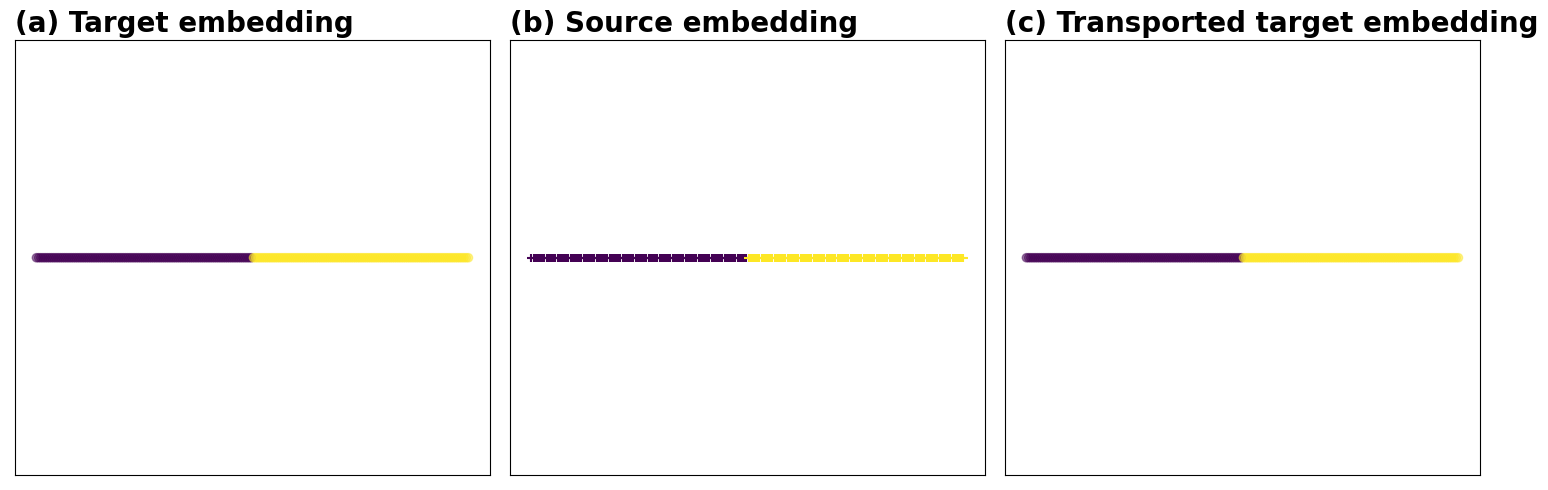

In [16]:
vis_emb_dim2_unordered(source_embs, source_labels, target_embs, target_labels, trans_target_embs)

In [17]:
def compute_stats(true_labels, trans_target_embs):
    """ 
    Compute f1 score using x=0
    """
    pred_labels = []
    for emb in trans_target_embs:
        if emb[0] >= 0:
            pred_labels.append(1)
        else:
            pred_labels.append(0)
    return 1-accuracy_score(true_labels, pred_labels)



In [22]:
wa_dists = []
f1_scores = []
for noise in np.arange(0, 30, 0.1):
    target_embs, target_labels, source_embs, source_labels = gen_emb_label(noise)
    ot_emd = ot.da.EMDTransport(log=True)
    ot_emd.fit(Xs=np.array(target_embs), Xt=np.array(source_embs))
    trans_target_embs = ot_emd.transform(Xs=target_embs)
    wa_dists.append(ot_emd.log_['cost'])
    f1_scores.append(compute_stats(target_labels, trans_target_embs))

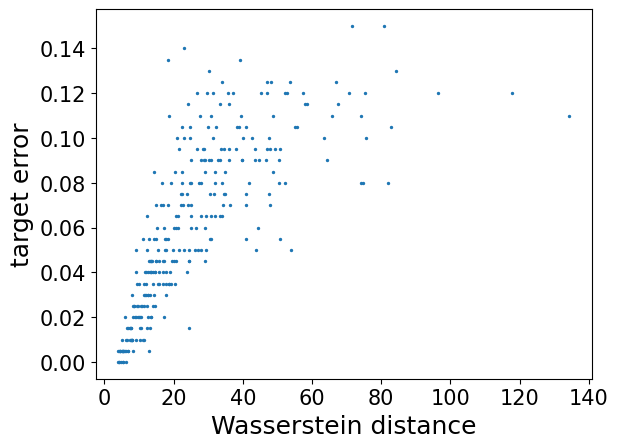

In [23]:
textsize=18
plt.scatter(wa_dists, f1_scores, s=2)
plt.xlabel('Wasserstein distance', fontsize=18)
plt.xticks(fontsize=15)
plt.ylabel('target error', fontsize=18)
plt.yticks(fontsize=15)
save_path = os.path.join(output_dir, "sim10_res.pdf")
plt.savefig(save_path, bbox_inches ='tight')